
# Estimating COVID-19's spread within population based on $R_o$ and other boundary conditions

Katz - May 4, 2020

*This Notebook offers a quantitative studdy of the various factors contributing the intensity of an infection outbreak Like COVID-19*.  
We utilizae the SIR (susceptible-infected-recovered) epidemiological model.  
Note1: For a more fatal diseases "recovered" is also understood to be removed".  
Note2: We assume that all "Suseptable" subjects could be indiscriminately "Exposed" 
* S: susceptible
* E: exposed
* I: infected
* R: removed

### References   
*   https://labblog.uofmhealth.org/rounds/how-scientists-quantify-intensity-of-an-outbreak-like-covid-19
*   https://wwwnc.cdc.gov/eid/article/25/1/17-1901_article
*   https://web.stanford.edu/~jhj1/teachingdocs/Jones-on-R0.pdf
*   https://web.stanford.edu/~jhj1/teachingdocs/Jones-Epidemics050308.pdf

In [ ]:
import pprint
import random
import matplotlib.pyplot as plt

## Simulation Input Parameters
* ***R0*** Pronounced “R naught,”, also known as *Reproduction Number*, describes how many cases of a disease an infected person will go on to cause. In the senario of R0=2, each infected person would infect two others, which in turn infect two more, etc. 
* ***ros*** is a list of *RO*'s to run mutiple sequential simulations
* ***herd_imunity*** We assume that people develop immunity due to prior exposure with the pathogen. Therefore, the effective Ro changes over time and is an estimate based on a more realistic situation within the population. If set to *True*, the ***Ro*** will be dinamically adjusted tp reflect its dynamic nature. If set to *False*, ***Ro*** will remain static thrue the simulation 
* ***suscep_population***	is the number of susceptible individuals within population.  
* ***infected_day_zero*** is the number of persons assumed to be infected at the begging of simulation
* ***illness_dur*** is duration of contagiousness after a person becomes infected. For covid-19 we assume that the person is equally contagious throughout the infection. 
* ***infection_algorithm*** describes a method of calculation of when during th e contageous period the person infects others
* ***sim_length*** maximum legth of simulation in days. In most of teh cases no change required
* ***debug*** set above 0 to get increasing verbosity of debug logs 

## Simulation outputs 
Calculate the daily pandemic state:
*   number of infected individuals
*   number of recovered/removed individuals
*   various graphs





  

In [ ]:
# Sample lists of RO's - Uncomment one or create your own 
#ROs = [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0] + \
#       [3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
#ROs = [2.0, 3.0, 4.0]
ROs = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
#ROs = [2.0]

sim_inputs = {
  'ROs'                 : ROs,
  'herd_imunity'        : True,
  'suscep_population'   : 1000000,
  'infected_day_zero'   : 100,
  'illness_dur'         : 21,
  'infection_algorithm' : "random",
  'sim_length'          : 1000,
  'debug'               : 0
}

# Declare/initialize global results structures to support multiple
#  sequential simulations
results = {}
results['avail_healthy_pop']          = 0
results["tot_active_cases_daily"]     = {}
results["tot_infection_days"]         = {}
results["tot_recovery_days"]          = {}
results["tot_max_active_cases_daily"] = [0] * len(sim_inputs["ROs"])
results["tot_max_sim_lengh"]          = [0] * len(sim_inputs["ROs"])


## General Setup 

In [ ]:
# configure pretty print 
pp = pprint.PrettyPrinter(indent=4)
# matplotlib config
colors = ("yellowgreen", "seashell", "beige",
          "lightgrey", "honeydew", "mintcream",
          "mistyrose", "lightcyan", "lavender", "plum")
colors = colors + colors + colors + colors + colors # 50 colors
def plot_with_grid(plt):
  plt.legend()
  plt.minorticks_on()
  plt.grid(which='major', linestyle='-', linewidth='0.3', color='red')
  plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
  plt.show()

## Future infections and recoveries




Implement Function to predicy future infections and recoveries for a specific instance of illness based on various algorithms

1.   *infection_days* - when future infections will occure
2.   *recovery_days* - when infected folks will recover
3.   *start_day* - the current simulation day 


In [ ]:
if (sim_inputs['debug'] > 0):
  pp.pprint(sim_inputs)

# Predict future infection and recoveries based on various algorithms
def set_infections(infection_algorithm,
                   cur_Ro,
                   start_day,
                   infection_days,
                   recovery_days):
  assert (infection_algorithm in ("center", "random")), \
    "invalid algorithm input!"
  if infection_algorithm == "center":
    assert (int(cur_Ro)== cur_Ro), "fractional Ro not supported by \"center\"!"
    center = int(sim_inputs['illness_dur'] / 2)
    for i in range (0, cur_Ro):
      if(results['avail_healthy_pop'] > 0):
        infection_days[start_day + center] += 1
        results['avail_healthy_pop'] -= 1
        recovery_days[start_day + center + sim_inputs['illness_dur']] += 1
  elif infection_algorithm == "random":
    if(sim_inputs['herd_imunity']):
      cur_Ro = cur_Ro * \
        (results['avail_healthy_pop'] / sim_inputs['suscep_population'])
    int_Ro = int(cur_Ro)
    for i in range (0, int_Ro):
      if(results['avail_healthy_pop'] > 0):
        results['avail_healthy_pop'] -= 1
        rand_i_day = random.randint(1, sim_inputs['illness_dur']-1)
        infection_days[start_day + rand_i_day] += 1
        recovery_days[start_day + rand_i_day + sim_inputs['illness_dur']] += 1
    frac_Ro = int((cur_Ro - int_Ro) * 100) 
    if frac_Ro != 0:
      if (frac_Ro > random.randint(0, 99)):
        if(results['avail_healthy_pop'] > 0):
          results['avail_healthy_pop'] -= 1
          rand_i_day = random.randint(1, sim_inputs['illness_dur']-1)
          infection_days[start_day + rand_i_day] += 1
          recovery_days[start_day + rand_i_day + sim_inputs['illness_dur']] += 1
  return


## Function to run one istance of simulation per Ro


In [ ]:

# main function to run one istance of simulation (per Ro)
def run_one_sim(Ro, sim_index):
  # Initialize simulation data 
  active_cases_daily= [0] * sim_inputs['sim_length']
  infection_days     = [0] * sim_inputs['sim_length']
  recovery_days      = [0] * sim_inputs['sim_length']
  results['avail_healthy_pop'] = sim_inputs['suscep_population']
  cur_Ro = Ro
  last_sim_day = 0
  max_active_cases_daily= 0

  # Initialize for first batch of sick
  # ASSUME that they are all getting sick on the fisrt day - days '0'
  if( sim_inputs['debug'] > 0):
    print("\n===> Ro = ", Ro)
    print("===> INITIALIZING SIM WITH FIRST INFECTED BATCH")
    print("===> Already Infected = ", sim_inputs['infected_day_zero'])
    print("=> day = ", 0)
  for x in range(0, sim_inputs['infected_day_zero']):
    if( sim_inputs['debug'] > 1):
      print ("===> Person = ", x)
    results['avail_healthy_pop'] -= 1;
    # set all days of the illness and recovery for the starting batch
    for y in range(0, sim_inputs['illness_dur']):
      active_cases_daily[y] += 1
    infection_days[0] += 1
    recovery_days[sim_inputs['illness_dur']-1] += 1
    # predict when they will infect others 
    set_infections(sim_inputs["infection_algorithm"],
                   cur_Ro,
                   0,
                   infection_days,
                   recovery_days)

  print( "======> RUNNING SIMULATION <======")
  for day in range(1, sim_inputs['sim_length'] - sim_inputs['illness_dur']*2):
    if( sim_inputs['debug'] > 0):
      print("=> day = ", day)
    # for each newly infected person on this day
    for num in range(0, infection_days[day]):
      # update the fuure sick days for the duration of the illness 
      for y in range(0, sim_inputs['illness_dur']):
          active_cases_daily[day + y] += 1
      if results['avail_healthy_pop'] > 0:      
        # predict when they will infect others and when infected will recover
        set_infections(sim_inputs["infection_algorithm"], 
                       cur_Ro,
                       day,
                       infection_days,
                       recovery_days)
      # update pick infected/sick maximum for this simulation 
      if max_active_cases_daily< active_cases_daily[day]:
        max_active_cases_daily= active_cases_daily[day]
    if( sim_inputs['debug'] > 0):
      print("===> Got infected this day = ", infection_days[day])
      print("===> Sick people this day  = ", active_cases_daily[day])
      print("===> Recovered this day    = ", recovery_days[day])
      print("===> Avail healthy pop     = ", results['avail_healthy_pop'])
      print("===> Future Infections     = ", sum(infection_days[(day+1):]))
      print("===> Future Recoveries     = ", sum(recovery_days[(day+1):]))
      print("===> Total Got Sick        = ", sum(infection_days[:(day+1)]))
      print("===> Total Sick Days       = ", sum(active_cases_daily))
      print("===> Tot.Expected Sick Days= ", sum(infection_days[:(day+1)]) * 
                                                 sim_inputs['illness_dur']) 
      print("===> Total Recovered       = ", sum(recovery_days[:(day+1)]))
      print("===> Total Population      = ", sim_inputs['suscep_population'])
      if( sim_inputs['debug'] > 2):
        print("infection_days:")
        pp.pprint(infection_days)
        print("recovery_days:")
        pp.pprint(recovery_days)
        print("active_cases_daily:")
        pp.pprint(active_cases_daily)

    # End simulation if no pending activity
    if ((sum(infection_days[(day+1):]) == 0) and
        (sum(recovery_days[(day+1):]) == 0) and
        (sum(active_cases_daily[(day):])  == 0)):
      break

  # Log results  
  last_sim_day = day
  print("===> Simulation ended on day = ", last_sim_day)
  print("===> Ro                      = ", Ro)
  print("===> Illness Duration        = ", sim_inputs['illness_dur']) 
  print("===> Total recovered         = ", sum(recovery_days[:(day+1)]))
  print("===> Total got sick          = ", sum(infection_days[:(day+1)]))
  print("===> Have not gotten sick    = ", results['avail_healthy_pop'])
  print("===> Max active cases dayly  = ", max_active_cases_daily)
  # print("===> Total sick days       = ", sum(active_cases_daily[:(day+1)]))

  if( sim_inputs['debug'] > 2):
    print("infection_days:")
    pp.pprint(infection_days)
    print("recovery_days:")
    pp.pprint(recovery_days)
    print("active_cases_daily:")
    pp.pprint(active_cases_daily)
  
  # Store simulation totals
  results["tot_active_cases_daily"][sim_index]     = active_cases_daily.copy()
  results["tot_infection_days"][sim_index]         = infection_days.copy()
  results["tot_recovery_days"][sim_index]          = recovery_days.copy()
  results["tot_max_active_cases_daily"][sim_index] = max_active_cases_daily
  results["tot_max_sim_lengh"][sim_index]          = last_sim_day

# --------------------------------
#       The Main Run function
# --------------------------------
for i in range(len(sim_inputs["ROs"])): 
  run_one_sim(sim_inputs["ROs"][i], i)
last_sim_day = max(results["tot_max_sim_lengh"])
# --------------------------------

======> RUNNING SIMULATION <======
===> Simulation ended on day =  548
===> Ro                      =  1.5
===> Illness Duration        =  21
===> Total recovered         =  577568
===> Total got sick          =  577568
===> Have not gotten sick    =  422432
===> Max active cases dayly  =  121629
======> RUNNING SIMULATION <======
===> Simulation ended on day =  296
===> Ro                      =  2.0
===> Illness Duration        =  21
===> Total recovered         =  793334
===> Total got sick          =  793334
===> Have not gotten sick    =  206666
===> Max active cases dayly  =  287796
======> RUNNING SIMULATION <======
===> Simulation ended on day =  247
===> Ro                      =  2.5
===> Illness Duration        =  21
===> Total recovered         =  890339
===> Total got sick          =  890339
===> Have not gotten sick    =  109661
===> Max active cases dayly  =  420261
======> RUNNING SIMULATION <======
===> Simulation ended on day =  205
===> Ro                      =  3.0

## PLOT Ro vs. Max Max Active Cases Daily

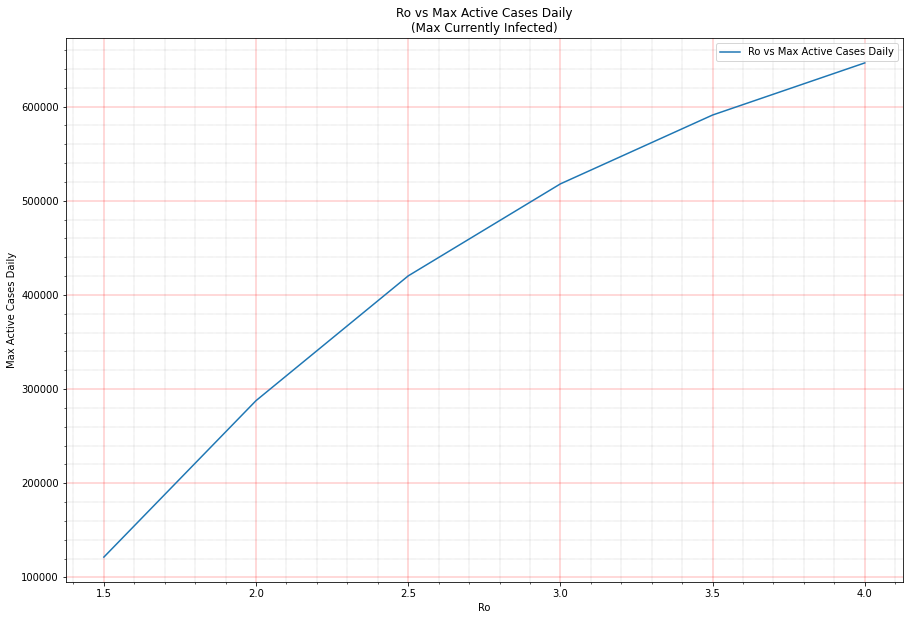

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(sim_inputs["ROs"],
         results["tot_max_active_cases_daily"], 
         label="Ro vs Max Active Cases Daily")
plt.xlabel("Ro")
plt.ylabel("Max Active Cases Daily")
plt.title("Ro vs Max Active Cases Daily\n(Max Currently Infected)")
plot_with_grid(plt)

## PLOT NEW INFECTIONS



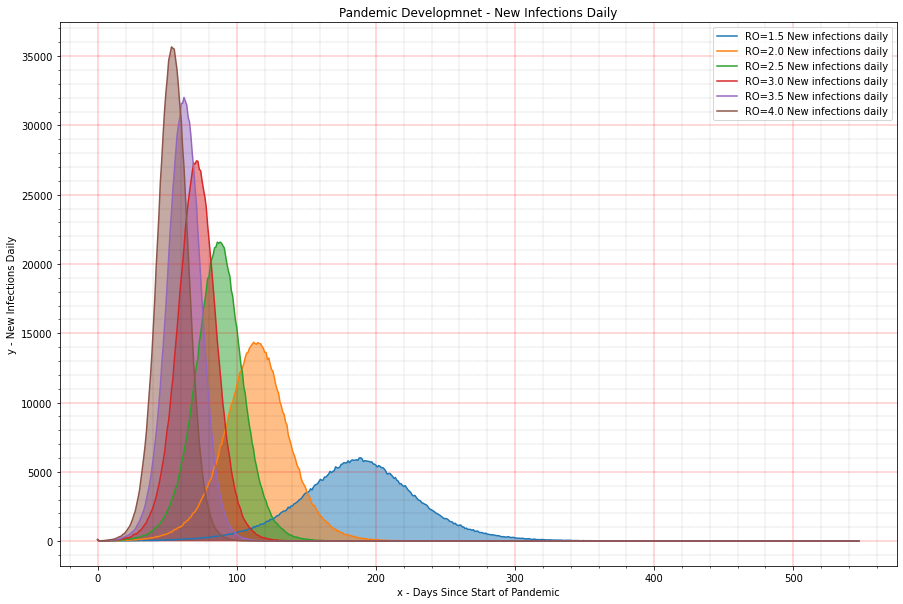

In [ ]:
# set x axes array: value = index
x = [x for x in range(last_sim_day)]

# LINE CHART WITH FILL
plt.figure(figsize=(15,10))
for i in range(len(sim_inputs["ROs"])):
  ys = results["tot_infection_days"][i][0:last_sim_day]
  str_label = "RO=" + str(sim_inputs["ROs"][i]) + " New infections daily"
  plt.plot(x, ys, label=str_label)
  plt.fill_between(x,
                   ys,
                   #facecolor=colors[i],
                   alpha=0.5)
plt.xlabel("x - Days Since Start of Pandemic")
plt.ylabel("y - New Infections Daily")
plt.title("Pandemic Developmnet - New Infections Daily")
plot_with_grid(plt)

## Plot Accumulated Infections



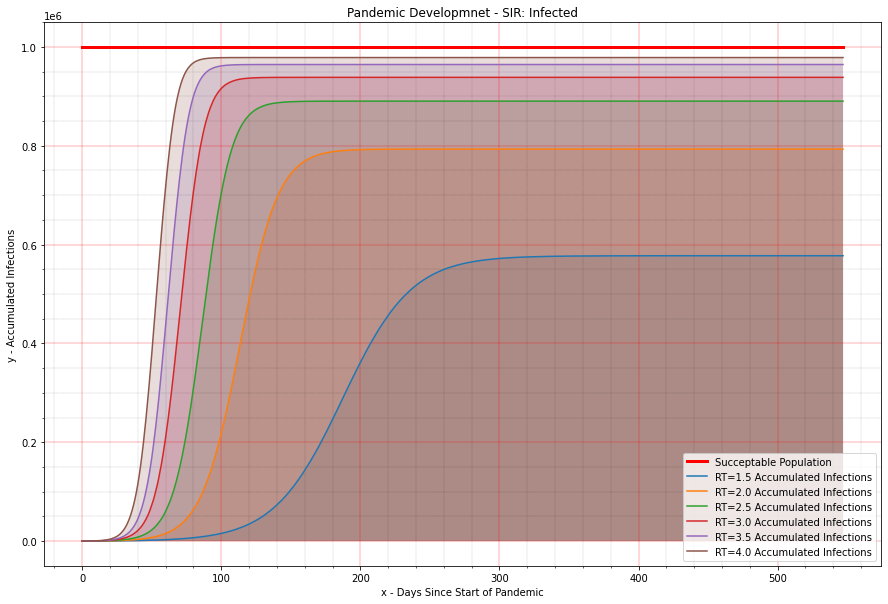

In [ ]:
# set x axes array: value = index
x = [x for x in range(last_sim_day)]
# set total population line
z  = [sim_inputs['suscep_population']] * last_sim_day

# ACCUMULATING LINE CHART
plt.figure(figsize=(15,10))
plt.plot(x, z, label="Succeptable Population", linewidth='3', color='red')
for i in range(len(sim_inputs["ROs"])):
  infections = results["tot_infection_days"][i][0:last_sim_day]
  ys = [ys for ys in range(len(infections))]
  for j in range(1, len(infections)):
    ys[j] = ys[j-1] + infections[j]
  str_label = "RT=" + str(sim_inputs["ROs"][i]) + " Accumulated Infections"
  plt.plot(x, ys, label=str_label)
  plt.fill_between(x,
                   ys,
                   alpha=0.2)
plt.xlabel("x - Days Since Start of Pandemic")
plt.ylabel("y - Accumulated Infections")
plt.title("Pandemic Developmnet - SIR: Infected")
plot_with_grid(plt)


## PLOT SICK PEOPLE DAILY

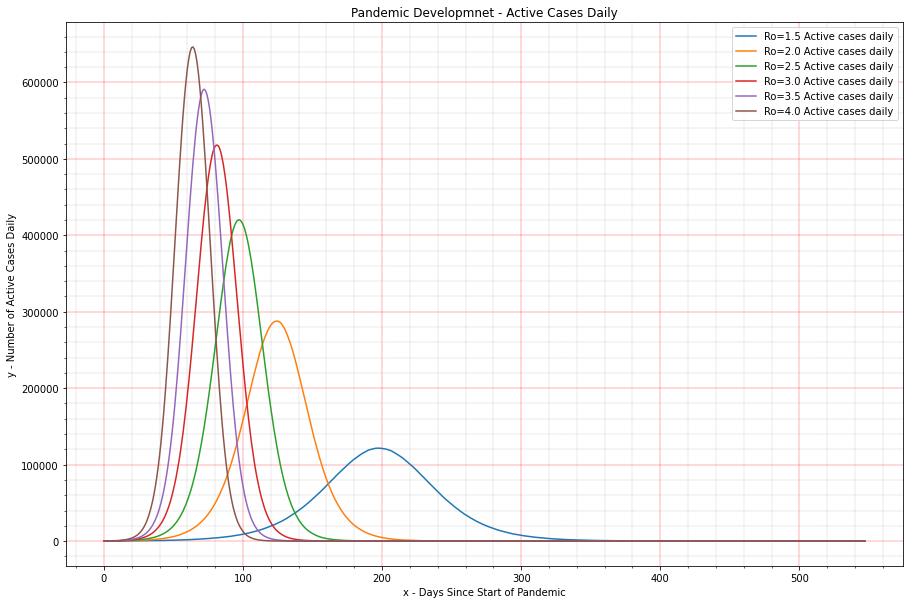

In [ ]:
plt.figure(figsize=(15,10))
# set x axes array
x = [x for x in range(last_sim_day)]

for i in range(len(sim_inputs["ROs"])):
  str_label = "Ro=" + str(sim_inputs["ROs"][i]) + " Active cases daily"
  plt.plot(x, results["tot_active_cases_daily"][i][0:last_sim_day], label=str_label)
plt.xlabel("x - Days Since Start of Pandemic")
plt.ylabel("y - Number of Active Cases Daily")
plt.title("Pandemic Developmnet - Active Cases Daily")
plot_with_grid(plt)

 ## Plot all info for the first Ro in the input list 

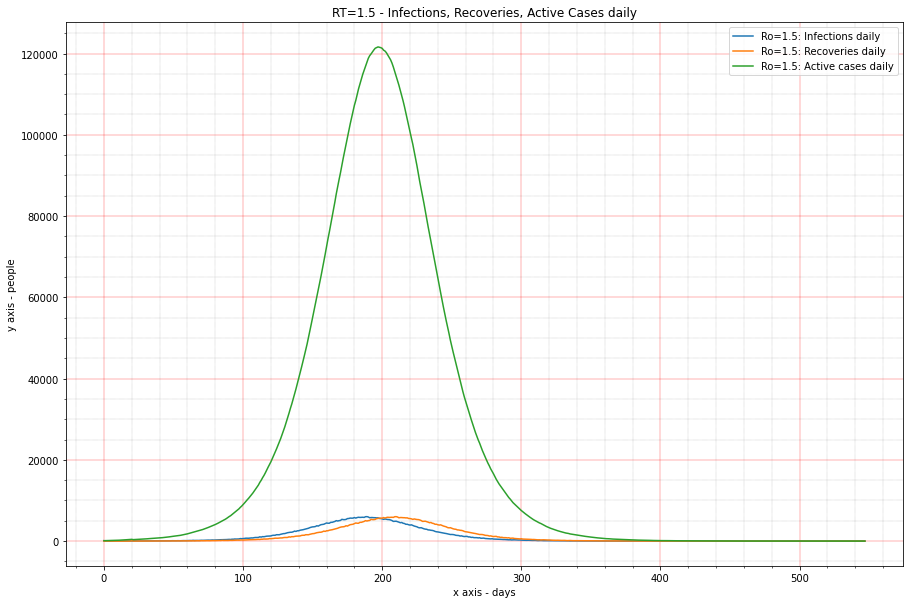

In [ ]:
plt.figure(figsize=(15,10))
# set x axes array: value = index
x = [x for x in range(last_sim_day)]
ro = str(sim_inputs["ROs"][0])

plt.plot(x, results["tot_infection_days"][0][0:last_sim_day], 
         label="Ro=" + ro + ": Infections daily")
plt.plot(x, results["tot_recovery_days"][0][0:last_sim_day],
         label="Ro=" + ro + ": Recoveries daily")
plt.plot(x, results["tot_active_cases_daily"][0][0:last_sim_day],
         label="Ro=" + ro + ": Active cases daily")

plt.xlabel("x axis - days")
plt.ylabel("y axis - people")
plt.title("RT=" + ro + " - Infections, Recoveries, Active Cases daily")

plot_with_grid(plt)

## Plot/Ilustrate the SIR Epidemic Model for the first Ro in the input list 


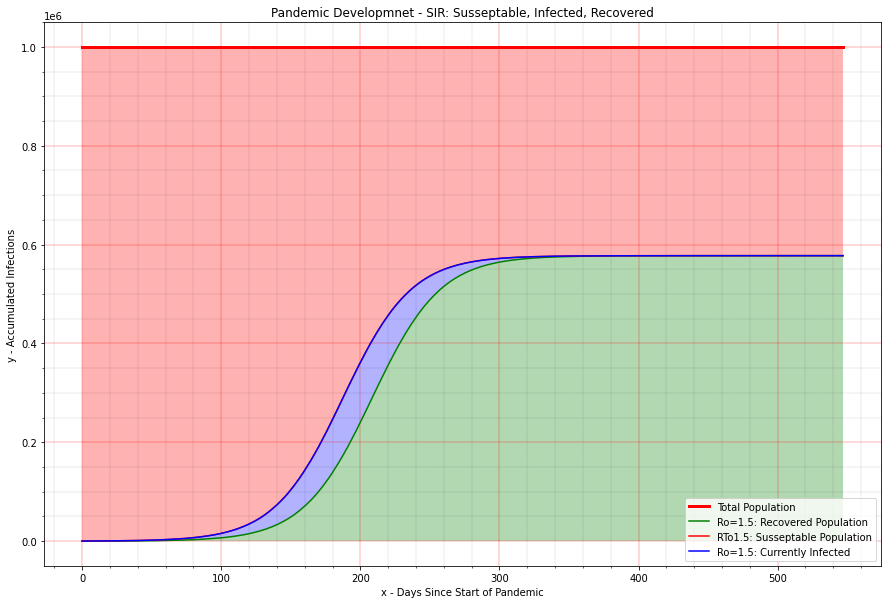

In [ ]:
# set x axes array: value = index
x = [x for x in range(last_sim_day)]
# set total population line
z  = [sim_inputs['suscep_population']] * last_sim_day

#  ACCUMULATING LINE CHART
plt.figure(figsize=(15,10))
plt.plot(x, z, label="Total Population", linewidth='3', color='red')

infections = results["tot_infection_days"][0][0:last_sim_day]
recoveries = results["tot_recovery_days"][0][0:last_sim_day]
sick       = results["tot_active_cases_daily"][0][0:last_sim_day]
ro         = str(sim_inputs["ROs"][0])

# Recovered Population 
yr = [yr for yr in range(last_sim_day)]
for j in range(1, last_sim_day):
  yr[j] = yr[j-1] + recoveries[j]
str_label = "Ro=" + ro + ": Recovered Population"
plt.plot(x, yr, label=str_label, color="green")
plt.fill_between(x,
                 yr,
                 facecolor="green",
                 alpha=0.3)

# Currently Infected/Sick Population 
# offset by recovered to plot over it
yi = [yi for yi in range(last_sim_day)]
for i in range (0, last_sim_day):
  yi[i] = sick[i] + yr[i]

# Susseptable Population 
# Use number of recoveries and infected to calc remaining suseptable population
ys = [ys for ys in range(last_sim_day)]
for j in range(0, last_sim_day):
  ys[j] = yr[j] + sick[j]
str_label = "RTo" + ro + ": Susseptable Population"
plt.plot(x, ys, label=str_label, color="red")
plt.fill_between(x,
                 ys,
                 z,
                 facecolor="red",
                 alpha=0.3)

# Plot sick/indfected
str_label = "Ro=" + ro + ": Currently Infected"
plt.plot(x, yi, label=str_label, color="blue")
plt.fill_between(x,
                 yi,
                 yr,
                 facecolor="blue",
                 alpha=0.3)

plt.xlabel("x - Days Since Start of Pandemic")
plt.ylabel("y - Accumulated Infections")
plt.title("Pandemic Developmnet - SIR: Susseptable, Infected, Recovered")
plot_with_grid(plt)